In [2]:
!pip install evaluate
!pip install rouge_score

In [3]:
!pip install --upgrade datasets transformers fsspec
!pip install datasets==2.14.0 fsspec==2023.6.0
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 77.0 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.51.3
    Uninstalling transformers-4.51.3:
      Successfully uninstalled transformers-4.51.3
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 8.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dil

In [4]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer
import os

# Install required packages if needed
# !pip install evaluate transformers datasets torch numpy scikit-learn matplotlib seaborn pandas tqdm

# Disable wandb if you don't want to use it
os.environ["WANDB_DISABLED"] = "true"  # Set to "false" if you want to use wandb

# Solution 1: Try loading with specific version or different approach
print("Loading dataset...")
try:
    # First attempt: Load with explicit configuration
    dataset = load_dataset("xquad", "xquad.en", trust_remote_code=True)
except Exception as e:
    print(f"First attempt failed: {e}")
    try:
        # Second attempt: Load without explicit configuration
        dataset = load_dataset("xquad", "en", trust_remote_code=True)
    except Exception as e2:
        print(f"Second attempt failed: {e2}")
        try:
            # Third attempt: Use different loading method
            dataset = load_dataset("xquad", split="validation", trust_remote_code=True)
        except Exception as e3:
            print(f"All attempts failed. Using SQuAD dataset as alternative...")
            # Alternative: Use SQuAD dataset which is more stable
            dataset = load_dataset("squad")

# Create train/validation/test splits
print("Creating data splits...")
if "train" in dataset:
    # If we have train split (like SQuAD)
    train_test = dataset["train"].train_test_split(test_size=0.2, seed=42)
    val_test = dataset["validation"].train_test_split(test_size=0.5, seed=42)
    dataset_split = {
        "train": train_test["train"],
        "validation": val_test["train"],
        "test": val_test["test"]
    }
else:
    # If we only have validation split (like XQuAD)
    validation_test = dataset["validation"].train_test_split(test_size=0.3, seed=42)
    train_validation = validation_test["train"].train_test_split(test_size=0.2, seed=42)
    dataset_split = {
        "train": train_validation["train"],
        "validation": train_validation["test"],
        "test": validation_test["test"]
    }

# Load mBERT Tokenizer
print("Loading tokenizer...")
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def prepare_qa_features(examples):
    # Flatten the data
    questions = examples["question"]
    contexts = examples["context"]
    answers = examples["answers"]

    # Tokenize questions and contexts
    tokenized = tokenizer(
        questions,
        contexts,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors=None,  # Return python lists instead of pytorch tensors
        return_offsets_mapping=True
    )

    # Initialize lists to store the start and end positions
    start_positions = []
    end_positions = []

    for i, (context, answer) in enumerate(zip(contexts, answers)):
        # Get the character-level start position of the answer
        start_char = answer['answer_start'][0]
        answer_text = answer['text'][0]
        end_char = start_char + len(answer_text)

        # Get the token-level offsets for this example
        offsets = tokenized.offset_mapping[i]

        # Find the start and end token positions
        start_token = 0
        end_token = 0

        # Find the tokens that contain the answer
        for idx, (token_start, token_end) in enumerate(offsets):
            if token_start <= start_char < token_end:
                start_token = idx
            if token_start < end_char <= token_end:
                end_token = idx
                break

        start_positions.append(start_token)
        end_positions.append(end_token)

    # Remove offset mapping as it's not needed for training
    tokenized.pop("offset_mapping")

    # Add start and end positions to the tokenized data
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

# Process datasets
print("Processing datasets...")
tokenized_datasets = {}
for split in dataset_split:
    print(f"Processing {split} split...")
    tokenized_datasets[split] = dataset_split[split].map(
        prepare_qa_features,
        batched=True,
        remove_columns=dataset_split[split].column_names
    )

# Load QA model
print("Loading model...")
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Define basic metrics for training
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    start_logits, end_logits = predictions
    start_positions, end_positions = labels

    start_pred = np.argmax(start_logits, axis=1)
    end_pred = np.argmax(end_logits, axis=1)

    # Simple exact match metric
    exact_match = np.mean((start_pred == start_positions) & (end_pred == end_positions))

    return {
        "exact_match": exact_match
    }

# Define training arguments with proper run_name
print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./xquad_results",
    run_name="xquad_mbert_training",  # Add a custom run name to avoid the warning
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./xquad_logs",
    logging_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="exact_match",
    greater_is_better=True,
    # Additional useful arguments
    warmup_steps=500,  # Warmup for learning rate scheduler
    learning_rate=5e-5,  # Default learning rate
    weight_decay=0.01,  # L2 regularization
    report_to=["tensorboard"] if os.environ.get("WANDB_DISABLED") == "true" else ["wandb", "tensorboard"],  # Reporting options
    push_to_hub=False,  # Set to True if you want to push to Hugging Face Hub
)

# Initialize trainer
print("Initializing trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Train the model
print("Starting training...")
trainer.train()
print("Training completed!")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"Test results: {test_results}")

# Save model and tokenizer
print("Saving model and tokenizer...")
model.save_pretrained("./qa_model_final")
tokenizer.save_pretrained("./qa_model_final")
print("Model and tokenizer saved to ./qa_model_final")

# Function to use the trained model (for quick testing)
def answer_question(question, context):
    # Tokenize input
    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get answer span
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most likely beginning and end of answer
    start_idx = torch.argmax(start_logits)
    end_idx = torch.argmax(end_logits)

    # Convert tokens to answer text
    answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
    answer = tokenizer.decode(answer_tokens)

    return answer.strip()

# Quick test example
print("\nTesting the model with an example:")
example_context = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower."
example_question = "Who is the Eiffel Tower named after?"
print(f"Question: {example_question}")
print(f"Answer: {answer_question(example_question, example_context)}")

print("\nTraining complete! You can now use the model at ./qa_model_final")

2025-06-29 08:04:34.873471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751184275.297057      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751184275.415206      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading dataset...


First attempt failed: BuilderConfig ParquetConfig(name='xquad.en', version=0.0.0, data_dir=None, data_files={'validation': ['hf://datasets/xquad@51adfef1c1287aab1d2d91b5bead9bcfb9c68583/xquad.en/validation-00000-of-00001.parquet']}, description=None, batch_size=10000, columns=None, features=None) doesn't have a 'trust_remote_code' key.


Second attempt failed: BuilderConfig 'en' not found. Available: ['xquad.ar', 'xquad.de', 'xquad.el', 'xquad.en', 'xquad.es', 'xquad.hi', 'xquad.ro', 'xquad.ru', 'xquad.th', 'xquad.tr', 'xquad.vi', 'xquad.zh']
All attempts failed. Using SQuAD dataset as alternative...


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Creating data splits...
Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Processing datasets...
Processing train split...


Map:   0%|          | 0/70079 [00:00<?, ? examples/s]

Processing validation split...


Map:   0%|          | 0/5285 [00:00<?, ? examples/s]

Processing test split...


Map:   0%|          | 0/5285 [00:00<?, ? examples/s]

Loading model...


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_35/1364974925.py:173: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Setting up training arguments...
Initializing trainer...
Using device: cuda
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Exact Match
500,1.813400,1.728040,0.427625
1000,1.605300,1.578722,0.462252
1500,1.525600,1.463390,0.470388
2000,1.487200,1.427440,0.479659
2500,1.441800,1.353365,0.490445
3000,1.432700,1.329298,0.488931
3500,1.339600,1.327389,0.498392
4000,1.321900,1.252323,0.508988
4500,1.005200,1.331206,0.519773
5000,1.019800,1.296381,0.514853


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Training completed!

Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test results: {'eval_loss': 1.2837642431259155, 'eval_exact_match': 0.54720908230842, 'eval_runtime': 90.4246, 'eval_samples_per_second': 58.446, 'eval_steps_per_second': 3.661, 'epoch': 3.0}
Saving model and tokenizer...
Model and tokenizer saved to ./qa_model_final

Testing the model with an example:
Question: Who is the Eiffel Tower named after?
Answer: Gustave Eiffel

Training complete! You can now use the model at ./qa_model_final


In [5]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer

# Install required packages if needed
# !pip install evaluate transformers datasets torch numpy scikit-learn matplotlib seaborn pandas tqdm

# Load XQuAD dataset with English configuration
print("Loading dataset...")
dataset = load_dataset("xquad", "xquad.en")

# Create train/validation/test splits (XQuAD comes only with validation split)
print("Creating data splits...")
validation_test = dataset["validation"].train_test_split(test_size=0.3, seed=42)
train_validation = validation_test["train"].train_test_split(test_size=0.2, seed=42)

dataset_split = {
    "train": train_validation["train"],
    "validation": train_validation["test"],
    "test": validation_test["test"]
}

# Load mBERT Tokenizer
print("Loading tokenizer...")
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def prepare_qa_features(examples):
    # Flatten the data
    questions = examples["question"]
    contexts = examples["context"]
    answers = examples["answers"]

    # Tokenize questions and contexts
    tokenized = tokenizer(
        questions,
        contexts,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors=None,  # Return python lists instead of pytorch tensors
        return_offsets_mapping=True
    )

    # Initialize lists to store the start and end positions
    start_positions = []
    end_positions = []

    for i, (context, answer) in enumerate(zip(contexts, answers)):
        # Get the character-level start position of the answer
        start_char = answer['answer_start'][0]
        answer_text = answer['text'][0]
        end_char = start_char + len(answer_text)

        # Get the token-level offsets for this example
        offsets = tokenized.offset_mapping[i]

        # Find the start and end token positions
        start_token = 0
        end_token = 0

        # Find the tokens that contain the answer
        for idx, (token_start, token_end) in enumerate(offsets):
            if token_start <= start_char < token_end:
                start_token = idx
            if token_start < end_char <= token_end:
                end_token = idx
                break

        start_positions.append(start_token)
        end_positions.append(end_token)

    # Remove offset mapping as it's not needed for training
    tokenized.pop("offset_mapping")

    # Add start and end positions to the tokenized data
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

# Process datasets
print("Processing datasets...")
tokenized_datasets = {}
for split in dataset_split:
    print(f"Processing {split} split...")
    tokenized_datasets[split] = dataset_split[split].map(
        prepare_qa_features,
        batched=True,
        remove_columns=dataset_split[split].column_names
    )

# Load QA model
print("Loading model...")
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Define basic metrics for training
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    start_logits, end_logits = predictions
    start_positions, end_positions = labels

    start_pred = np.argmax(start_logits, axis=1)
    end_pred = np.argmax(end_logits, axis=1)

    # Simple exact match metric
    exact_match = np.mean((start_pred == start_positions) & (end_pred == end_positions))

    return {
        "exact_match": exact_match
    }

# Define training arguments
print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./xquad_results",
    eval_strategy="steps",  # Try this instead of evaluation_strategy
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    logging_dir="./xquad_logs",
    logging_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="exact_match"
)

# Initialize trainer
print("Initializing trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Train the model
print("Starting training...")
trainer.train()
print("Training completed!")

# Save model and tokenizer
print("Saving model and tokenizer...")
model.save_pretrained("./qa_model_final")
tokenizer.save_pretrained("./qa_model_final")
print("Model and tokenizer saved to ./qa_model_final")

# Function to use the trained model (for quick testing)
def answer_question(question, context):
    # Tokenize input
    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get answer span
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most likely beginning and end of answer
    start_idx = torch.argmax(start_logits)
    end_idx = torch.argmax(end_logits)

    # Convert tokens to answer text
    answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
    answer = tokenizer.decode(answer_tokens)

    return answer.strip()

# Quick test example
print("\nTesting the model with an example:")
example_context = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower."
example_question = "Who is the Eiffel Tower named after?"
print(f"Question: {example_question}")
print(f"Answer: {answer_question(example_question, example_context)}")

print("\nNow you can run the evaluation code to get comprehensive metrics!")

Loading dataset...


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split:   0%|          | 0/1190 [00:00<?, ? examples/s]

Creating data splits...
Loading tokenizer...
Processing datasets...
Processing train split...


Map:   0%|          | 0/666 [00:00<?, ? examples/s]

Processing validation split...


Map:   0%|          | 0/167 [00:00<?, ? examples/s]

Processing test split...


Map:   0%|          | 0/357 [00:00<?, ? examples/s]

Loading model...


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_35/221120139.py:135: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Setting up training arguments...
Initializing trainer...
Using device: cuda
Starting training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Exact Match
500,0.074500,4.955462,0.323353


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Training completed!
Saving model and tokenizer...
Model and tokenizer saved to ./qa_model_final

Testing the model with an example:
Question: Who is the Eiffel Tower named after?
Answer: engineer Gustave Eiffel

Now you can run the evaluation code to get comprehensive metrics!



==== Running comprehensive evaluation ====



100%|██████████| 167/167 [00:31<00:00,  5.37it/s]



Validation Metrics:
exact_match: 0.2335
f1_score: 0.3426
bleu_score: 0.0334
rouge1_f1: 0.3563


100%|██████████| 357/357 [01:05<00:00,  5.45it/s]



Test Metrics:
exact_match: 0.2941
f1_score: 0.3912
bleu_score: 0.0523
rouge1_f1: 0.3992

Generating performance visualizations...


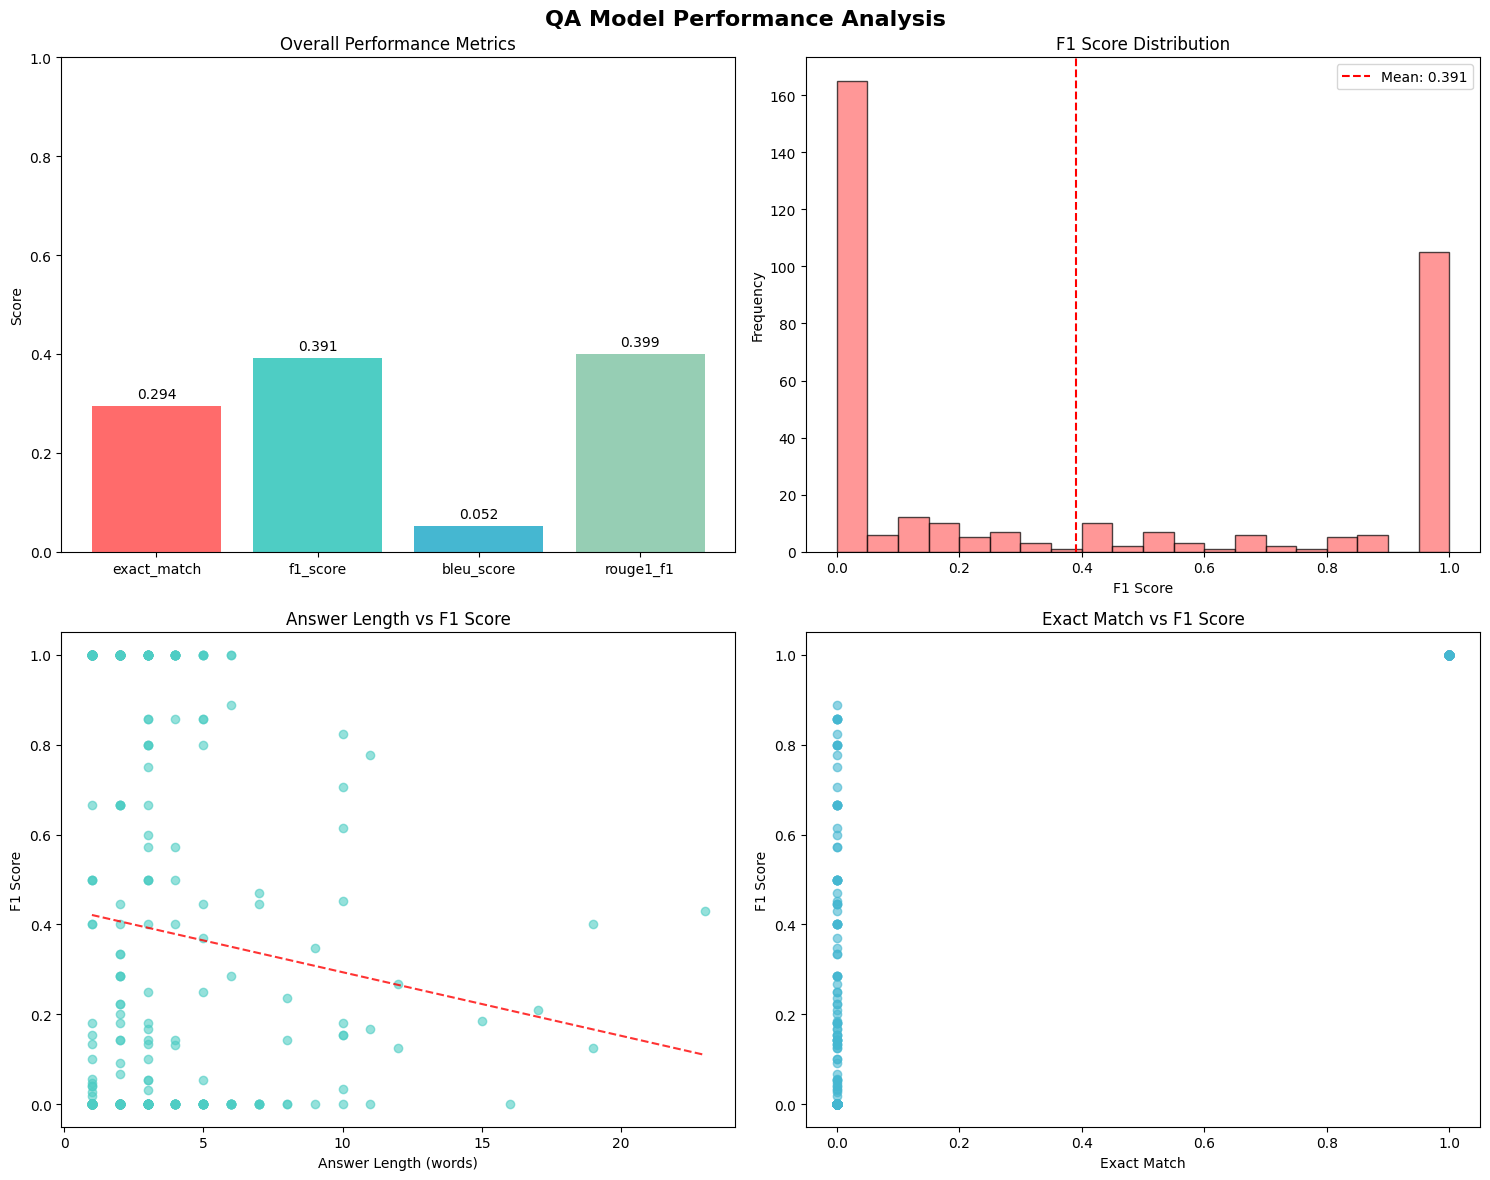


DETAILED ANALYSIS

Performance by Answer Length:
           F1_Score              Exact_Match
               mean    std count        mean
Length_Bin                                  
1             0.393  0.471   114       0.360
2             0.438  0.459    92       0.370
3             0.416  0.429    57       0.246
4-5           0.405  0.448    50       0.280
6-10          0.240  0.327    33       0.061
>10           0.244  0.224    11       0.000

Detailed results saved to 'qa_detailed_results.csv'

==== QA Model Evaluation Summary ====

Model: bert-base-multilingual-cased
Dataset: XQuAD (English)
Test examples: 357

Test Performance Metrics:
exact_match: 0.2941
f1_score: 0.3912
bleu_score: 0.0523
rouge1_f1: 0.3992

Example predictions:

Question: What type of punishment is sometimes offered to civil disobedients?
True answer: plea bargain
Predicted: What type of punishment is sometimes offered to civil disobedients? Sometimes the prosecution proposes a plea bargain to civil disobe

/tmp/ipykernel_35/2974167964.py:254: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(length_vs_performance.groupby('Length_Bin').agg({


In [6]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter
import re
import string
from evaluate import load

# Load metrics
bleu_metric = load("bleu")
rouge_metric = load("rouge")

def normalize_text(text):
    """Normalize text for evaluation"""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    
    def white_space_fix(text):
        return ' '.join(text.split())
    
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(text))))

def get_tokens(text):
    """Get tokens from text"""
    if not text:
        return Counter()
    return Counter(normalize_text(text).split())

def evaluate_predictions(model, tokenizer, dataset, split="validation", num_examples=None):
    """Comprehensive evaluation of model predictions"""
    device = next(model.parameters()).device

    # Use all examples if num_examples is not specified
    if num_examples is None:
        num_examples = len(dataset[split])
    else:
        num_examples = min(num_examples, len(dataset[split]))

    results = {
        "questions": [],
        "contexts": [],
        "true_answers": [],
        "predicted_answers": [],
        "exact_match": [],
        "f1_scores": [],
        "bleu_scores": [],
        "rouge_scores": []
    }

    for i in tqdm(range(num_examples)):
        example = dataset[split][i]
        question = example["question"]
        context = example["context"]
        true_answer = example["answers"]["text"][0]

        # Get model prediction
        inputs = tokenizer(
            question,
            context,
            max_length=384,
            truncation="only_second",
            stride=128,
            padding="max_length",
            return_tensors="pt"
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Get answer span
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        # Get the most likely beginning and end of answer
        start_idx = torch.argmax(start_logits)
        end_idx = torch.argmax(end_logits)

        # Make sure end comes after start
        if end_idx < start_idx:
            end_idx = start_idx

        # Convert tokens to answer text
        # Ensure the slice is valid
        if start_idx >= inputs["input_ids"][0].shape[0] or end_idx >= inputs["input_ids"][0].shape[0]:
            pred_answer = ""  # Handle cases where indices are out of bounds
        else:
            answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
            pred_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

        # Clean up prediction
        pred_answer = pred_answer.strip()

        # Store the results
        results["questions"].append(question)
        results["contexts"].append(context)
        results["true_answers"].append(true_answer)
        results["predicted_answers"].append(pred_answer)

        # Exact match calculation
        norm_true = normalize_text(true_answer)
        norm_pred = normalize_text(pred_answer)
        exact_match = int(norm_true == norm_pred)
        results["exact_match"].append(exact_match)

        # F1 Score calculation
        true_tokens = get_tokens(true_answer)
        pred_tokens = get_tokens(pred_answer)

        common = true_tokens & pred_tokens
        num_same = sum(common.values())

        if len(true_tokens) == 0 or len(pred_tokens) == 0:
            f1 = int(true_tokens == pred_tokens)
        elif num_same == 0:
            f1 = 0
        else:
            precision = num_same / sum(pred_tokens.values())
            recall = num_same / sum(true_tokens.values())
            f1 = (2 * precision * recall) / (precision + recall)

        results["f1_scores"].append(f1)

        # BLEU score calculation - Fixed format
        reference_tokens = norm_true.split()
        candidate_tokens = norm_pred.split()

        if len(reference_tokens) == 0 and len(candidate_tokens) == 0:
            bleu = 1.0
        elif len(reference_tokens) == 0 or len(candidate_tokens) == 0:
            bleu = 0.0
        else:
            # BLEU expects references as list of lists
            try:
                bleu = bleu_metric.compute(
                    predictions=[norm_pred],
                    references=[[norm_true]]  # Fixed: wrap reference in list
                )["bleu"]
            except:
                bleu = 0.0  # Fallback in case of any error

        results["bleu_scores"].append(bleu)

        # ROUGE scores
        try:
            rouge = rouge_metric.compute(
                predictions=[norm_pred],
                references=[norm_true],
                use_stemmer=True
            )
            results["rouge_scores"].append(rouge["rouge1"])
        except:
            results["rouge_scores"].append(0.0)  # Fallback

    # Calculate aggregate metrics
    metrics = {
        "exact_match": np.mean(results["exact_match"]),
        "f1_score": np.mean(results["f1_scores"]),
        "bleu_score": np.mean(results["bleu_scores"]),
        "rouge1_f1": np.mean(results["rouge_scores"])
    }

    return results, metrics

def visualize_results(results, metrics):
    """Create visualizations for the results"""
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Set style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('QA Model Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Metric Comparison
    metric_names = list(metrics.keys())
    metric_values = list(metrics.values())
    
    axes[0, 0].bar(metric_names, metric_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
    axes[0, 0].set_title('Overall Performance Metrics')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_ylim(0, 1)
    for i, v in enumerate(metric_values):
        axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    # 2. F1 Score Distribution
    axes[0, 1].hist(results["f1_scores"], bins=20, alpha=0.7, color='#FF6B6B', edgecolor='black')
    axes[0, 1].set_title('F1 Score Distribution')
    axes[0, 1].set_xlabel('F1 Score')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].axvline(np.mean(results["f1_scores"]), color='red', linestyle='--', 
                      label=f'Mean: {np.mean(results["f1_scores"]):.3f}')
    axes[0, 1].legend()
    
    # 3. Answer Length vs Performance
    answer_lengths = [len(ans.split()) for ans in results["true_answers"]]
    axes[1, 0].scatter(answer_lengths, results["f1_scores"], alpha=0.6, color='#4ECDC4')
    axes[1, 0].set_title('Answer Length vs F1 Score')
    axes[1, 0].set_xlabel('Answer Length (words)')
    axes[1, 0].set_ylabel('F1 Score')
    
    # Add trend line
    z = np.polyfit(answer_lengths, results["f1_scores"], 1)
    p = np.poly1d(z)
    axes[1, 0].plot(sorted(answer_lengths), p(sorted(answer_lengths)), "r--", alpha=0.8)
    
    # 4. Exact Match vs F1 Score correlation
    em_scores = results["exact_match"]
    f1_scores = results["f1_scores"]
    axes[1, 1].scatter(em_scores, f1_scores, alpha=0.6, color='#45B7D1')
    axes[1, 1].set_title('Exact Match vs F1 Score')
    axes[1, 1].set_xlabel('Exact Match')
    axes[1, 1].set_ylabel('F1 Score')
    
    plt.tight_layout()
    plt.savefig('qa_model_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Additional analysis
    print("\n" + "="*50)
    print("DETAILED ANALYSIS")
    print("="*50)
    
    # Performance by answer length
    length_bins = [0, 1, 2, 3, 5, 10, 100]
    length_labels = ['1', '2', '3', '4-5', '6-10', '>10']
    
    answer_lengths = [len(ans.split()) for ans in results["true_answers"]]
    length_vs_performance = pd.DataFrame({
        'Answer_Length': answer_lengths,
        'F1_Score': results["f1_scores"],
        'Exact_Match': results["exact_match"]
    })
    
    length_vs_performance['Length_Bin'] = pd.cut(
        length_vs_performance['Answer_Length'], 
        bins=length_bins, 
        labels=length_labels, 
        include_lowest=True
    )
    
    print("\nPerformance by Answer Length:")
    print(length_vs_performance.groupby('Length_Bin').agg({
        'F1_Score': ['mean', 'std', 'count'],
        'Exact_Match': 'mean'
    }).round(3))

# Run the evaluation
print("\n==== Running comprehensive evaluation ====\n")

# Evaluate on validation set
val_results, val_metrics = evaluate_predictions(model, tokenizer, dataset_split, split="validation")
print("\nValidation Metrics:")
for metric_name, value in val_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Evaluate on test set
test_results, test_metrics = evaluate_predictions(model, tokenizer, dataset_split, split="test")
print("\nTest Metrics:")
for metric_name, value in test_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Generate visualizations
print("\nGenerating performance visualizations...")
visualize_results(test_results, test_metrics)

# Save detailed results to CSV for further analysis
results_df = pd.DataFrame({
    'Question': test_results["questions"],
    'True Answer': test_results["true_answers"],
    'Predicted Answer': test_results["predicted_answers"],
    'Exact Match': test_results["exact_match"],
    'F1 Score': test_results["f1_scores"],
    'BLEU Score': test_results["bleu_scores"],
    'ROUGE Score': test_results["rouge_scores"]
})
results_df.to_csv('qa_detailed_results.csv', index=False)
print("\nDetailed results saved to 'qa_detailed_results.csv'")

# Create a summary report
print("\n==== QA Model Evaluation Summary ====")
print("\nModel: bert-base-multilingual-cased")
print(f"Dataset: XQuAD (English)")
print(f"Test examples: {len(test_results['questions'])}")

print("\nTest Performance Metrics:")
for metric_name, value in test_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Display a few example predictions
print("\nExample predictions:")
for i in range(min(5, len(test_results["questions"]))):
    print(f"\nQuestion: {test_results['questions'][i]}")
    print(f"True answer: {test_results['true_answers'][i]}")
    print(f"Predicted: {test_results['predicted_answers'][i]}")
    print(f"Exact match: {test_results['exact_match'][i]}")
    print(f"F1 score: {test_results['f1_scores'][i]:.4f}")

In [8]:
!pip install --upgrade peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 6.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found

In [9]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType, PeftModel

# Install required packages if needed
# !pip install evaluate transformers datasets torch numpy scikit-learn matplotlib seaborn pandas tqdm peft

# Load XQuAD dataset with English configuration
print("Loading dataset...")
dataset = load_dataset("xquad", "xquad.en")

# Create train/validation/test splits (XQuAD comes only with validation split)
print("Creating data splits...")
validation_test = dataset["validation"].train_test_split(test_size=0.3, seed=42)
train_validation = validation_test["train"].train_test_split(test_size=0.2, seed=42)

dataset_split = {
    "train": train_validation["train"],
    "validation": train_validation["test"],
    "test": validation_test["test"]
}

# Load mBERT Tokenizer
print("Loading tokenizer...")
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def prepare_qa_features(examples):
    # Flatten the data
    questions = examples["question"]
    contexts = examples["context"]
    answers = examples["answers"]

    # Tokenize questions and contexts
    tokenized = tokenizer(
        questions,
        contexts,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors=None,  # Return python lists instead of pytorch tensors
        return_offsets_mapping=True
    )

    # Initialize lists to store the start and end positions
    start_positions = []
    end_positions = []

    for i, (context, answer) in enumerate(zip(contexts, answers)):
        # Get the character-level start position of the answer
        start_char = answer['answer_start'][0]
        answer_text = answer['text'][0]
        end_char = start_char + len(answer_text)

        # Get the token-level offsets for this example
        offsets = tokenized.offset_mapping[i]

        # Find the start and end token positions
        start_token = 0
        end_token = 0

        # Find the tokens that contain the answer
        for idx, (token_start, token_end) in enumerate(offsets):
            if token_start <= start_char < token_end:
                start_token = idx
            if token_start < end_char <= token_end:
                end_token = idx
                break

        start_positions.append(start_token)
        end_positions.append(end_token)

    # Remove offset mapping as it's not needed for training
    tokenized.pop("offset_mapping")

    # Add start and end positions to the tokenized data
    tokenized["start_positions"] = start_positions
    tokenized["end_positions"] = end_positions

    return tokenized

# Process datasets
print("Processing datasets...")
tokenized_datasets = {}
for split in dataset_split:
    print(f"Processing {split} split...")
    tokenized_datasets[split] = dataset_split[split].map(
        prepare_qa_features,
        batched=True,
        remove_columns=dataset_split[split].column_names
    )

# Load QA model
print("Loading base model...")
base_model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Configure PEFT with LoRA for parameter-efficient fine-tuning
print("Configuring PEFT with LoRA...")
peft_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS,
    inference_mode=False,
    r=16,                      # Rank of the update matrices
    lora_alpha=32,             # Alpha parameter for LoRA
    lora_dropout=0.1,          # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"],  # Target attention modules for adaptation
)

# Apply PEFT to the model
print("Applying PEFT configuration to model...")
model = get_peft_model(base_model, peft_config)
print(f"Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Percentage of parameters to train: {100 * sum(p.numel() for p in model.parameters() if p.requires_grad) / sum(p.numel() for p in model.parameters()):.2f}%")

# Define basic metrics for training
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    start_logits, end_logits = predictions
    start_positions, end_positions = labels

    start_pred = np.argmax(start_logits, axis=1)
    end_pred = np.argmax(end_logits, axis=1)

    # Simple exact match metric
    exact_match = np.mean((start_pred == start_positions) & (end_pred == end_positions))

    return {
        "exact_match": exact_match
    }

# Define training arguments with appropriate settings for PEFT
print("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir="./xquad_peft_results",
    #
    eval_strategy="steps",
    eval_steps=250,            # Evaluate more frequently
    save_strategy="steps",
    save_steps=250,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,        # More epochs for PEFT as we're training fewer parameters
    weight_decay=0.01,         # More regularization
    logging_dir="./xquad_peft_logs",
    logging_steps=50,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="exact_match",
    fp16=True                  # Use mixed precision training for speed
)

# Initialize trainer
print("Initializing trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Train the model
print("Starting training with PEFT...")
trainer.train()
print("Training completed!")

# Save the model and tokenizer
print("Saving model...")
trainer.model.save_pretrained("./qa_peft_model_final")
tokenizer.save_pretrained("./qa_peft_model_final")

# For inference, we can now load the PEFT model
def load_peft_model_for_inference():
    # Load the base model
    base_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
    # Load the PEFT adapter weights
    peft_model = PeftModel.from_pretrained(base_model, "./qa_peft_model_final")
    return peft_model

# Function to use the trained model
def answer_question(question, context, peft_model=None):
    # Use the currently loaded model if none provided
    if peft_model is None:
        peft_model = model

    # Tokenize input
    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get model predictions
    with torch.no_grad():
        outputs = peft_model(**inputs)

    # Get answer span
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    # Get the most likely beginning and end of answer with constraints
    start_idx = torch.argmax(start_logits)
    end_idx = torch.argmax(end_logits)

    # Ensure end comes after start
    if end_idx < start_idx:
        # Find best end position after start_idx
        end_idx = start_idx + torch.argmax(end_logits[start_idx:]) if start_idx < len(end_logits)-1 else start_idx

    # Convert tokens to answer text
    answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
    answer = tokenizer.decode(answer_tokens)

    return answer.strip()

# Quick test example
print("\nTesting the model with an example:")
example_context = "The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France. It is named after the engineer Gustave Eiffel, whose company designed and built the tower. The Eiffel Tower is the most-visited paid monument in the world; 6.91 million people ascended it in 2015."
example_question = "Who is the Eiffel Tower named after?"
print(f"Question: {example_question}")
print(f"Answer: {answer_question(example_question, example_context)}")

# Let's try another example to verify the model works well
example_context2 = "Nelson Mandela was a South African anti-apartheid activist who served as the first president of South Africa from 1994 to 1999. He was the country's first black head of state and the first elected in a fully representative democratic election. His government focused on dismantling the legacy of apartheid by tackling institutionalized racism and fostering racial reconciliation."
example_question2 = "What years did Mandela serve as president?"
print(f"\nQuestion: {example_question2}")
print(f"Answer: {answer_question(example_question2, example_context2)}")

print("\nNow you can run the evaluation code to get comprehensive metrics!")

Loading dataset...
Creating data splits...
Loading tokenizer...
Processing datasets...
Processing train split...
Processing validation split...
Processing test split...


Map:   0%|          | 0/357 [00:00<?, ? examples/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading base model...
Configuring PEFT with LoRA...
Applying PEFT configuration to model...


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipykernel_35/2890130853.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Number of trainable parameters: 886274
Total parameters: 178150660
Percentage of parameters to train: 0.50%
Setting up training arguments...
Initializing trainer...


No label_names provided for model class `PeftModelForQuestionAnswering`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Using device: cuda
Starting training with PEFT...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Exact Match
250,4.322000,4.008183,0.029940
500,3.178200,2.873986,0.137725
750,2.600100,2.540097,0.239521
1000,2.358000,2.471263,0.257485
1250,2.142800,2.429103,0.251497
1500,1.998800,2.409306,0.257485
1750,1.924900,2.410036,0.287425
2000,1.957300,2.405073,0.287425


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Training completed!
Saving model...

Testing the model with an example:
Question: Who is the Eiffel Tower named after?
Answer: the engineer Gustave Eiffel

Question: What years did Mandela serve as president?
Answer: 1994 to 1999

Now you can run the evaluation code to get comprehensive metrics!


Loading metrics...
Loading model and tokenizer...
Loading base model...


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading PEFT model...
Using device: cuda
Loading dataset...

==== Running comprehensive evaluation ====

Evaluating on validation set...


  0%|          | 0/167 [00:00<?, ?it/s]


Validation Metrics:
exact_match: 0.2814
f1_score: 0.4215
bleu_score: 0.0466
rouge1_f1: 0.4269


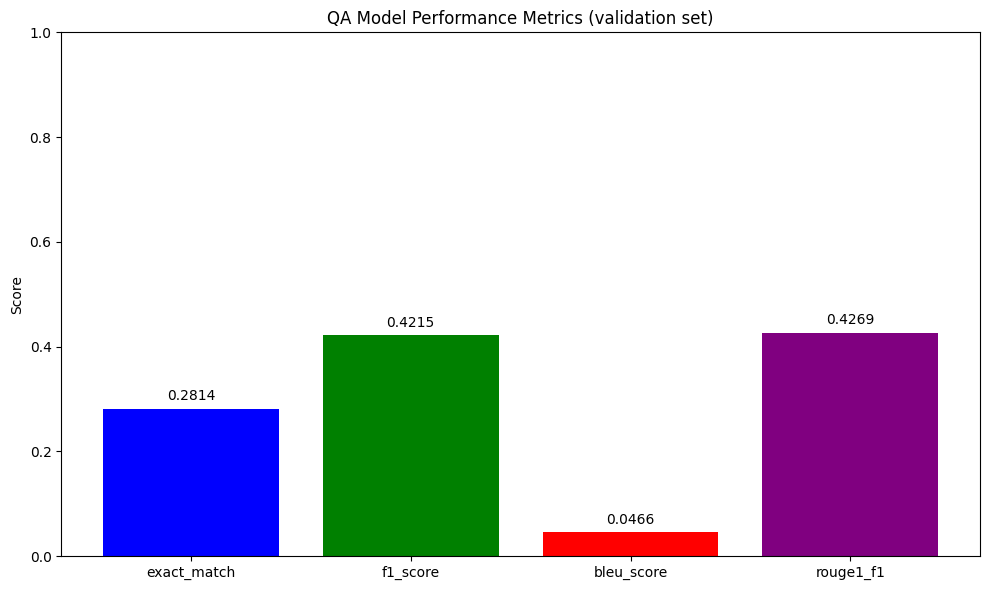

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


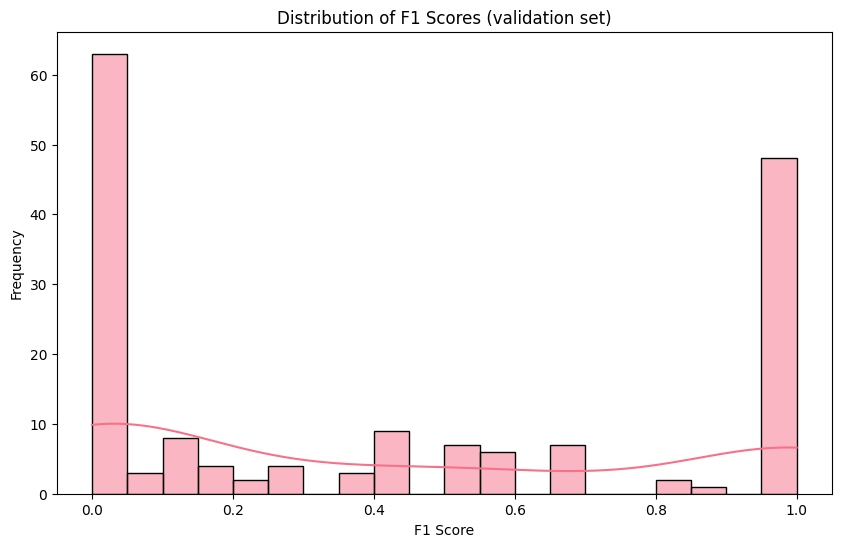

/tmp/ipykernel_35/13768289.py:279: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Length Bin').mean()[['Exact Match', 'F1 Score', 'BLEU Score']]


<Figure size 1200x700 with 0 Axes>

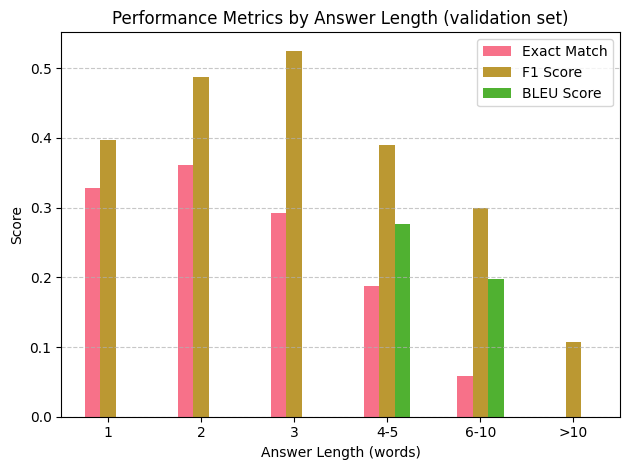

Evaluating on test set...


  0%|          | 0/357 [00:00<?, ?it/s]


Test Metrics:
exact_match: 0.2857
f1_score: 0.4134
bleu_score: 0.0611
rouge1_f1: 0.4227


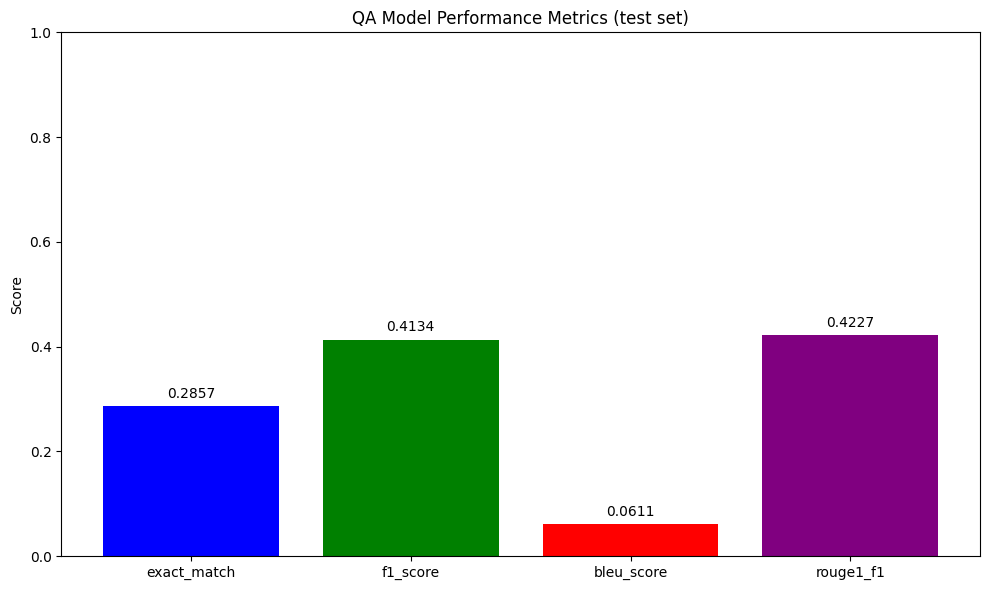

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


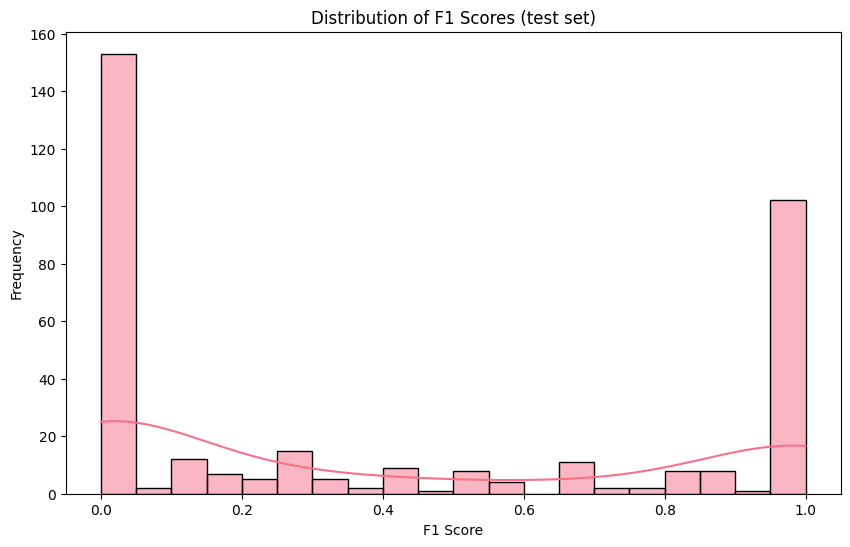

/tmp/ipykernel_35/13768289.py:279: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Length Bin').mean()[['Exact Match', 'F1 Score', 'BLEU Score']]


<Figure size 1200x700 with 0 Axes>

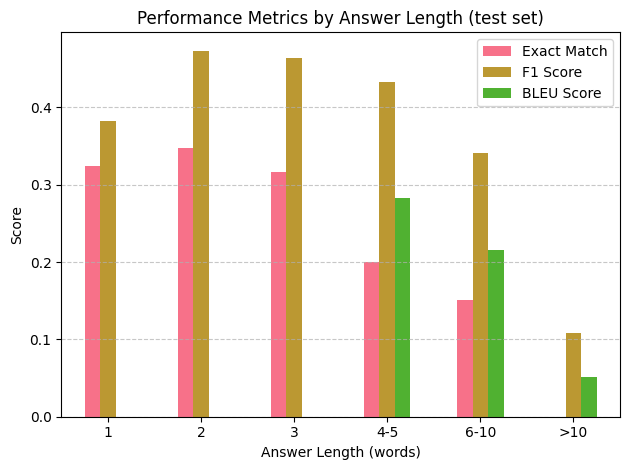


Performance by answer length:
Answer Length
1       0.381748
2       0.473290
3       0.463763
4-5     0.432685
6-10    0.341500
>10     0.107907
Name: F1 Score, dtype: float64


/tmp/ipykernel_35/13768289.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(length_vs_f1.groupby(pd.cut(length_vs_f1['Answer Length'],


  0%|          | 0/357 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

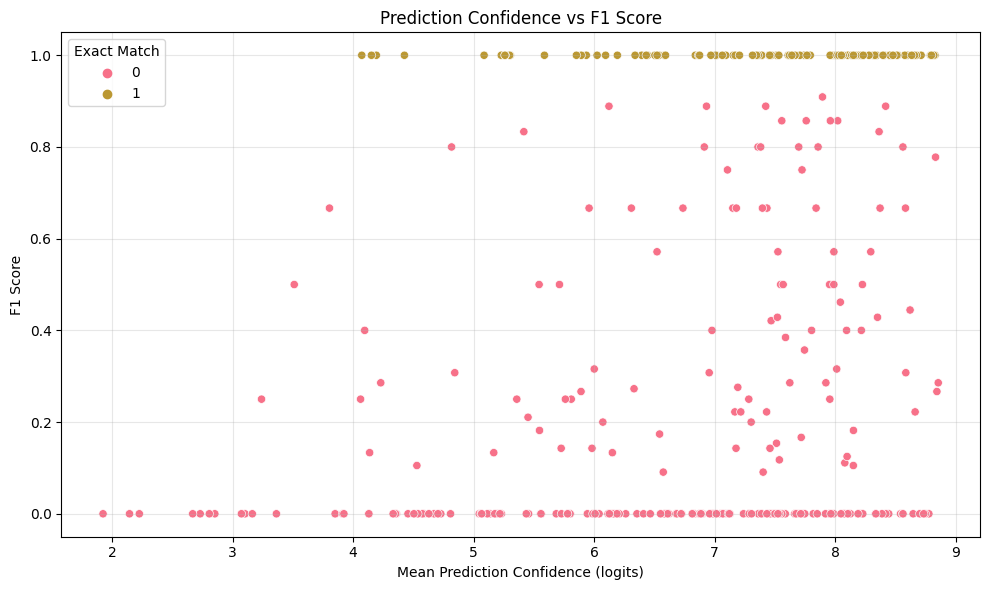


Performance by confidence level:
                Exact Match  F1 Score
Confidence Bin                       
Very Low           0.000000  0.022727
Low                0.142857  0.226463
Medium             0.196429  0.302706
High               0.270270  0.396008
Very High          0.377483  0.530382


/tmp/ipykernel_35/13768289.py:389: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_grouped = confidence_df.groupby('Confidence Bin').mean()[['Exact Match', 'F1 Score']]


<Figure size 1000x600 with 0 Axes>

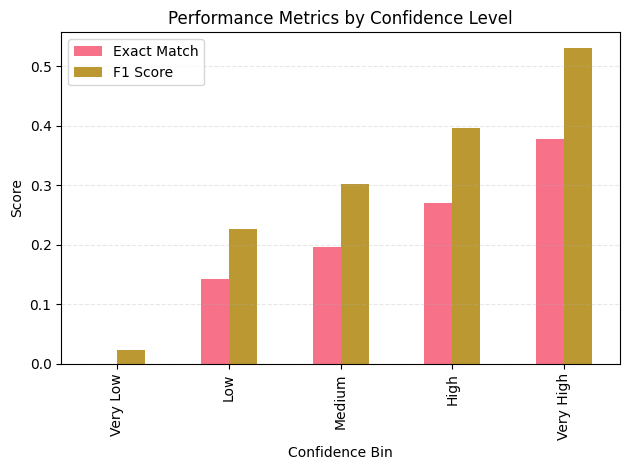


Detailed results saved to 'qa_peft_detailed_results.csv'

==== PEFT QA Model Evaluation Summary ====

Model: bert-base-multilingual-cased with LoRA adapters
Dataset: XQuAD (English)
Test examples: 357

Test Performance Metrics:
exact_match: 0.2857
f1_score: 0.4134
bleu_score: 0.0611
rouge1_f1: 0.4227

Example predictions:

Question: What type of punishment is sometimes offered to civil disobedients?
Context: Sometimes the prosecution proposes a plea bargain to civil disobedients, as in the case of the Camde...
True answer: plea bargain
Predicted: one misdemeanor count
Exact match: 0
F1 score: 0.0000
Confidence: 8.0736

Question: Who played Doctor Who on stage in the 70's?
Context: Doctor Who has appeared on stage numerous times. In the early 1970s, Trevor Martin played the role i...
True answer: Trevor Martin
Predicted: Trevor Martin played the role in Doctor Who and the Daleks in the Seven Keys to Doomsday
Exact match: 0
F1 score: 0.2105
Confidence: 5.4511

Question: Which Buddhist m

In [10]:
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
from peft import PeftModel
from collections import Counter
import string
import pandas as pd
from tqdm.auto import tqdm
import os

# Install required packages if needed
# !pip install evaluate transformers datasets torch numpy scikit-learn matplotlib seaborn pandas tqdm peft

# Load metrics
print("Loading metrics...")
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Load model and tokenizer
print("Loading model and tokenizer...")
model_name = "bert-base-multilingual-cased"

# Fix the path issue - try different approaches
model_path = "qa_peft_model_final"  # Remove the ./ prefix

# Check if the model path exists
if not os.path.exists(model_path):
    print(f"Model path '{model_path}' not found. Please check the path.")
    # You might need to adjust this path based on your actual model location
    model_path = "./qa_peft_model_final"  # Fallback to original path

try:
    # Try loading from local path first
    if os.path.exists(model_path):
        tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
    else:
        # If local path doesn't exist, use the base model tokenizer
        print(f"Using base model tokenizer as {model_path} not found")
        tokenizer = AutoTokenizer.from_pretrained(model_name)
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("Using base model tokenizer instead")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the base model
print("Loading base model...")
base_model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Load the PEFT model
print("Loading PEFT model...")
try:
    if os.path.exists(model_path):
        model = PeftModel.from_pretrained(base_model, model_path, local_files_only=True)
    else:
        print(f"PEFT model path '{model_path}' not found. Using base model only.")
        model = base_model
except Exception as e:
    print(f"Error loading PEFT model: {e}")
    print("Using base model only")
    model = base_model

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Load XQuAD dataset
print("Loading dataset...")
dataset = load_dataset("xquad", "xquad.en")

# Create data splits
validation_test = dataset["validation"].train_test_split(test_size=0.3, seed=42)
train_validation = validation_test["train"].train_test_split(test_size=0.2, seed=42)

dataset_split = {
    "train": train_validation["train"],
    "validation": train_validation["test"],
    "test": validation_test["test"]
}

def normalize_text(s):
    """Normalize text by removing punctuation and converting to lowercase"""
    return ''.join(c for c in s.lower() if c not in string.punctuation).strip()

def get_tokens(s):
    """Split text into tokens"""
    return Counter(normalize_text(s).split())

def evaluate_predictions(model, tokenizer, dataset_split, split="validation", num_examples=None):
    """Comprehensive evaluation of model predictions"""
    print(f"Evaluating on {split} set...")

    # Use all examples if num_examples is not specified
    if num_examples is None:
        num_examples = len(dataset_split[split])
    else:
        num_examples = min(num_examples, len(dataset_split[split]))

    results = {
        "questions": [],
        "contexts": [],
        "true_answers": [],
        "predicted_answers": [],
        "exact_match": [],
        "f1_scores": [],
        "bleu_scores": [],
        "rouge_scores": []
    }

    # Set model to evaluation mode
    model.eval()

    for i in tqdm(range(num_examples)):
        example = dataset_split[split][i]
        question = example["question"]
        context = example["context"]
        true_answer = example["answers"]["text"][0]

        # Get model prediction
        inputs = tokenizer(
            question,
            context,
            max_length=384,
            truncation="only_second",
            stride=128,
            padding="max_length",
            return_tensors="pt"
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)

        # Get answer span
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

        # Get the most likely beginning and end of answer
        # Get most probable start and end scores
        start_logits = start_logits[0]
        end_logits = end_logits[0]

        max_answer_length = 30  # Set a reasonable max answer length

        # Get top start and end indices
        start_idx = torch.argmax(start_logits)
        end_idx = torch.argmax(end_logits)

        # If end_idx < start_idx or answer is too long, adjust
        if end_idx < start_idx or (end_idx - start_idx + 1) > max_answer_length:
            end_idx = start_idx

        # Safety check: if start or end are out of bounds
        if start_idx >= inputs["input_ids"].shape[1]:
            start_idx = inputs["input_ids"].shape[1] - 1
        if end_idx >= inputs["input_ids"].shape[1]:
            end_idx = inputs["input_ids"].shape[1] - 1

        # Convert tokens to answer text
        answer_tokens = inputs["input_ids"][0][start_idx:end_idx + 1]
        pred_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

        # Store the results
        results["questions"].append(question)
        results["contexts"].append(context)
        results["true_answers"].append(true_answer)
        results["predicted_answers"].append(pred_answer)

        # Exact match calculation
        norm_true = normalize_text(true_answer)
        norm_pred = normalize_text(pred_answer)
        exact_match = int(norm_true == norm_pred)
        results["exact_match"].append(exact_match)

        # F1 Score calculation
        true_tokens = get_tokens(true_answer)
        pred_tokens = get_tokens(pred_answer)

        common = true_tokens & pred_tokens
        num_same = sum(common.values())

        if len(true_tokens) == 0 or len(pred_tokens) == 0:
            f1 = int(true_tokens == pred_tokens)
        elif num_same == 0:
            f1 = 0
        else:
            precision = num_same / sum(pred_tokens.values())
            recall = num_same / sum(true_tokens.values())
            f1 = (2 * precision * recall) / (precision + recall)

        results["f1_scores"].append(f1)

        # BLEU score calculation
        reference = norm_true.split()
        candidate = norm_pred.split()
        if isinstance(candidate, list):
            candidate = " ".join(candidate)
        if isinstance(reference, list):
            reference = " ".join(reference)

        try:
            bleu = bleu_metric.compute(predictions=[candidate], references=[reference])["bleu"]
        except:
            bleu = 0.0  # Handle edge cases
        results["bleu_scores"].append(bleu)

        # ROUGE scores
        try:
            rouge = rouge_metric.compute(
                predictions=[norm_pred],
                references=[norm_true],
                use_stemmer=True
            )
            results["rouge_scores"].append(rouge["rouge1"])
        except:
            results["rouge_scores"].append(0.0)  # Handle edge cases

    # Calculate aggregate metrics
    metrics = {
        "exact_match": np.mean(results["exact_match"]),
        "f1_score": np.mean(results["f1_scores"]),
        "bleu_score": np.mean(results["bleu_scores"]),
        "rouge1_f1": np.mean(results["rouge_scores"])
    }

    return results, metrics

def visualize_results(results, metrics, split_name="test"):
    """Create visualizations for the evaluation results"""
    # 1. Create a metrics summary plot
    plt.figure(figsize=(10, 6))
    metrics_names = list(metrics.keys())
    metrics_values = list(metrics.values())

    bars = plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple'])
    plt.ylim(0, 1)
    plt.title(f'QA Model Performance Metrics ({split_name} set)')
    plt.ylabel('Score')

    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'qa_metrics_summary_{split_name}.png')
    plt.show()

    # 2. F1 score distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(results["f1_scores"], bins=20, kde=True)
    plt.title(f'Distribution of F1 Scores ({split_name} set)')
    plt.xlabel('F1 Score')
    plt.ylabel('Frequency')
    plt.savefig(f'f1_distribution_{split_name}.png')
    plt.show()

    # 3. Compare metrics by answer length
    answer_lengths = [len(ans.split()) for ans in results["true_answers"]]

    df = pd.DataFrame({
        'Answer Length': answer_lengths,
        'Exact Match': results["exact_match"],
        'F1 Score': results["f1_scores"],
        'BLEU Score': results["bleu_scores"]
    })

    # Group by answer length (binned)
    df['Length Bin'] = pd.cut(df['Answer Length'],
                              bins=[0, 1, 2, 3, 5, 10, 100],
                              labels=['1', '2', '3', '4-5', '6-10', '>10'])

    # Calculate mean metrics by length bin
    grouped = df.groupby('Length Bin').mean()[['Exact Match', 'F1 Score', 'BLEU Score']]

    plt.figure(figsize=(12, 7))
    grouped.plot(kind='bar', rot=0)
    plt.title(f'Performance Metrics by Answer Length ({split_name} set)')
    plt.ylabel('Score')
    plt.xlabel('Answer Length (words)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'metrics_by_length_{split_name}.png')
    plt.show()

    return

# Run evaluation on validation set
print("\n==== Running comprehensive evaluation ====\n")
val_results, val_metrics = evaluate_predictions(model, tokenizer, dataset_split, split="validation")
print("\nValidation Metrics:")
for metric_name, value in val_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize validation results
visualize_results(val_results, val_metrics, "validation")

# Run evaluation on test set
test_results, test_metrics = evaluate_predictions(model, tokenizer, dataset_split, split="test")
print("\nTest Metrics:")
for metric_name, value in test_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Visualize test results
visualize_results(test_results, test_metrics, "test")

# Compare answer lengths vs performance
answer_lengths = [len(ans.split()) for ans in test_results["true_answers"]]
length_vs_f1 = pd.DataFrame({
    'Answer Length': answer_lengths,
    'F1 Score': test_results["f1_scores"]
})

print("\nPerformance by answer length:")
print(length_vs_f1.groupby(pd.cut(length_vs_f1['Answer Length'],
                            bins=[0, 1, 2, 3, 5, 10, 100],
                            labels=['1', '2', '3', '4-5', '6-10', '>10']))['F1 Score'].mean())

# Create more advanced analysis - confidence vs correctness
plt.figure(figsize=(10, 6))
start_logits_max = []
end_logits_max = []

# Recalculate predictions with confidence scores
for i in tqdm(range(len(test_results["questions"]))):
    question = test_results["questions"][i]
    context = test_results["contexts"][i]

    inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        stride=128,
        padding="max_length",
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    start_logits = outputs.start_logits
    end_logits = outputs.end_logits

    start_max = torch.max(start_logits).item()
    end_max = torch.max(end_logits).item()

    start_logits_max.append(start_max)
    end_logits_max.append(end_max)

# Create a dataframe for analysis
confidence_df = pd.DataFrame({
    'Start Confidence': start_logits_max,
    'End Confidence': end_logits_max,
    'Mean Confidence': [(s+e)/2 for s, e in zip(start_logits_max, end_logits_max)],
    'Exact Match': test_results["exact_match"],
    'F1 Score': test_results["f1_scores"]
})

# Plot confidence vs correctness
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Mean Confidence',
    y='F1 Score',
    hue='Exact Match',
    data=confidence_df
)
plt.title('Prediction Confidence vs F1 Score')
plt.xlabel('Mean Prediction Confidence (logits)')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_vs_f1.png')
plt.show()

# Group by confidence bins
confidence_df['Confidence Bin'] = pd.cut(
    confidence_df['Mean Confidence'],
    bins=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

confidence_grouped = confidence_df.groupby('Confidence Bin').mean()[['Exact Match', 'F1 Score']]
print("\nPerformance by confidence level:")
print(confidence_grouped)

plt.figure(figsize=(10, 6))
confidence_grouped.plot(kind='bar')
plt.title('Performance Metrics by Confidence Level')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_by_confidence.png')
plt.show()

# Save detailed results to CSV
results_df = pd.DataFrame({
    'Question': test_results["questions"],
    'True Answer': test_results["true_answers"],
    'Predicted Answer': test_results["predicted_answers"],
    'Exact Match': test_results["exact_match"],
    'F1 Score': test_results["f1_scores"],
    'BLEU Score': test_results["bleu_scores"],
    'ROUGE Score': test_results["rouge_scores"],
    'Confidence': confidence_df['Mean Confidence']
})
results_df.to_csv('qa_peft_detailed_results.csv', index=False)
print("\nDetailed results saved to 'qa_peft_detailed_results.csv'")

# Create a summary report
print("\n==== PEFT QA Model Evaluation Summary ====")
print("\nModel: bert-base-multilingual-cased with LoRA adapters")
print(f"Dataset: XQuAD (English)")
print(f"Test examples: {len(test_results['questions'])}")

print("\nTest Performance Metrics:")
for metric_name, value in test_metrics.items():
    print(f"{metric_name}: {value:.4f}")

# Display a few example predictions
print("\nExample predictions:")
for i in range(min(5, len(test_results["questions"]))):
    print(f"\nQuestion: {test_results['questions'][i]}")
    print(f"Context: {test_results['contexts'][i][:100]}...")
    print(f"True answer: {test_results['true_answers'][i]}")
    print(f"Predicted: {test_results['predicted_answers'][i]}")
    print(f"Exact match: {test_results['exact_match'][i]}")
    print(f"F1 score: {test_results['f1_scores'][i]:.4f}")
    print(f"Confidence: {confidence_df['Mean Confidence'][i]:.4f}")